## Data Generation and Plotting Utils

In [1]:
from pathlib import Path
output_dir = Path.cwd() / "../output"
output_dir.mkdir(parents=True, exist_ok=True)

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime

def generate_iid_noise(n_samples=1000, mean=0, std=1, frequency='H', start_date=None):
    """
    Generate time series with i.i.d. noise.
    
    Parameters:
    -----------
    n_samples : int
        Number of data points to generate
    mean : float
        Mean of the normal distribution
    std : float
        Standard deviation of the normal distribution
    frequency : str
        Pandas frequency string ('H' for hourly, 'D' for daily, etc.)
    start_date : datetime or str
        Starting date for the time series, defaults to current date
        
    Returns:
    --------
    pd.Series : Time series with i.i.d. noise
    """
    if start_date is None:
        start_date = datetime.now()
    elif isinstance(start_date, str):
        start_date = pd.to_datetime(start_date)
    
    # Generate timestamps
    timestamps = pd.date_range(start=start_date, periods=n_samples, freq=frequency)
    
    # Generate i.i.d. noise
    noise = np.random.normal(mean, std, n_samples)
    
    return pd.Series(noise, index=timestamps, name='iid_noise')

def generate_trend(n_samples=1000, trend_type='linear', slope=0.1, noise_level=0, frequency='H', start_date=None):
    """
    Generate time series with a trend component.
    
    Parameters:
    -----------
    n_samples : int
        Number of data points to generate
    trend_type : str
        Type of trend ('linear', 'quadratic', 'exponential')
    slope : float
        Slope parameter for the trend
    noise_level : float
        Standard deviation of the noise to add
    frequency : str
        Pandas frequency string ('H' for hourly, 'D' for daily, etc.)
    start_date : datetime or str
        Starting date for the time series, defaults to current date
        
    Returns:
    --------
    pd.Series : Time series with trend
    """
    if start_date is None:
        start_date = datetime.now()
    elif isinstance(start_date, str):
        start_date = pd.to_datetime(start_date)
    
    # Generate timestamps
    timestamps = pd.date_range(start=start_date, periods=n_samples, freq=frequency)
    
    # Generate time indices
    t = np.arange(n_samples)
    
    # Generate trend based on type
    if trend_type == 'linear':
        trend = slope * t
    elif trend_type == 'quadratic':
        trend = slope * t**2 / n_samples
    elif trend_type == 'exponential':
        # Scale down the time indices to slow the exponential growth
        scaled_t = slope * t / (n_samples / 50)  # Divide by (n_samples/10) to make growth much slower
        trend = np.exp(scaled_t) - 1
    else:
        raise ValueError("trend_type must be 'linear', 'quadratic', or 'exponential'")
    
    # Add noise
    noise = np.random.normal(0, noise_level, n_samples)
    values = trend + noise
    
    return pd.Series(values, index=timestamps, name='trend')

def generate_seasonal(n_samples=1000, period=24, amplitude=1, noise_level=0, frequency='H', start_date=None):
    """
    Generate time series with seasonal patterns.
    
    Parameters:
    -----------
    n_samples : int
        Number of data points to generate
    period : int
        Number of time steps in one seasonal cycle
    amplitude : float
        Amplitude of the seasonal component
    noise_level : float
        Standard deviation of the noise to add
    frequency : str
        Pandas frequency string ('H' for hourly, 'D' for daily, etc.)
    start_date : datetime or str
        Starting date for the time series, defaults to current date
        
    Returns:
    --------
    pd.Series : Time series with seasonal pattern
    """
    if start_date is None:
        start_date = datetime.now()
    elif isinstance(start_date, str):
        start_date = pd.to_datetime(start_date)
    
    # Generate timestamps
    timestamps = pd.date_range(start=start_date, periods=n_samples, freq=frequency)
    
    # Generate time indices
    t = np.arange(n_samples)
    
    # Generate seasonal component (sine wave)
    seasonal = amplitude * np.sin(2 * np.pi * t / period)
    
    # Add noise
    noise = np.random.normal(0, noise_level, n_samples)
    values = seasonal + noise
    
    return pd.Series(values, index=timestamps, name='seasonal')

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_time_series(series_list, figsize=(14, 10), split=None, title=None, separate=False):
    """
    Plot one or more time series.
    
    Parameters:
    -----------
    series_list : list of pd.Series or single pd.Series
        Time series to plot
    figsize : tuple
        Figure size (width, height)
    title : str
        Main title for the plot
    separate : bool
        If True, plot each series in a separate subplot
    """
    if not isinstance(series_list, list):
        series_list = [series_list]
    
    n_series = len(series_list)
    
    if separate:
        fig, axes = plt.subplots(n_series, 1, figsize=figsize, sharex=True)
        if n_series == 1:
            axes = [axes]
        
        for i, series in enumerate(series_list):
            ax = axes[i]
            ax.plot(series.index, series.values)
            ax.set_title(series.name if series.name else f"Series {i+1}")
            ax.grid(True, alpha=0.3)
            
            # Format x-axis dates based on frequency
            if len(series) > 0:
                freq = pd.infer_freq(series.index)
                if freq and ('D' in freq or 'W' in freq or 'M' in freq):
                    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
                    plt.xticks(rotation=45)
                elif freq and 'H' in freq:
                    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
                    plt.xticks(rotation=45)
            
            ax.set_ylabel('Value')
            ax.axvline(x=series.index[split], color='red', linestyle='--', alpha=0.5)
        
        axes[-1].set_xlabel('Time')
        if title:
            fig.suptitle(title, fontsize=16)
        plt.tight_layout()
        
    else:
        plt.figure(figsize=figsize)
        for series in series_list:
            plt.plot(series.index, series.values, label=series.name if series.name else "Series")
        
        # Format x-axis dates based on frequency of the first series
        if len(series_list) > 0 and len(series_list[0]) > 0:
            freq = pd.infer_freq(series_list[0].index)
            if freq and ('D' in freq or 'W' in freq or 'M' in freq):
                plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
                plt.xticks(rotation=45)
            elif freq and 'H' in freq:
                plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
                plt.xticks(rotation=45)
        
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.xlabel('Time')
        plt.ylabel('Value')
        # if split:
        #     plt.axvline(x=split, color='red', linestyle='--', alpha=0.5)
        if title:
            plt.title(title, fontsize=16)
        plt.tight_layout()
    
    plt.show()

In [4]:
from autogluon.timeseries import TimeSeriesDataFrame

def series_to_tsdf(series, item_id="default"):
    """
    Convert a pandas Series to TimeSeriesDataFrame format.
    
    Parameters:
    -----------
    series : pd.Series
        Time series data with datetime index
    item_id : str, default="default"
        Identifier for the time series
        
    Returns:
    --------
    TimeSeriesDataFrame
        The converted time series data in AutoGluon's TimeSeriesDataFrame format
    """
    # Reshape the series into a DataFrame with proper format
    df = pd.DataFrame({'target': series, "item_id": item_id})
    df.index.name = 'timestamp'  # Ensure index is named 'timestamp'
    df.reset_index(inplace=True)
    
    # Convert to TimeSeriesDataFrame
    return TimeSeriesDataFrame(df)

## Data Generation

In [5]:
context_length = 800
predict_length = 200
total_length = context_length + predict_length

noise_hourly = generate_iid_noise(n_samples=total_length, frequency='H', start_date='2023-01-01')
noise_weekly = generate_iid_noise(n_samples=total_length, frequency='H', start_date='2023-01-01', mean=100, std=10)
trend_hourly_linear = generate_trend(n_samples=total_length, frequency='H', start_date='2023-01-01')
trend_hourly_expo = generate_trend(n_samples=total_length, frequency='H', start_date='2023-01-01', trend_type='exponential')
seasonal_hourly = generate_seasonal(n_samples=total_length, period=24, frequency='H', start_date='2023-01-01')
seasonal_combined_hourly = generate_seasonal(n_samples=total_length, period=15, frequency='H', start_date='2023-01-01') + seasonal_hourly
add_linear_trend_hourly = trend_hourly_linear + seasonal_hourly
mul_linear_trend_hourly = trend_hourly_linear * seasonal_hourly

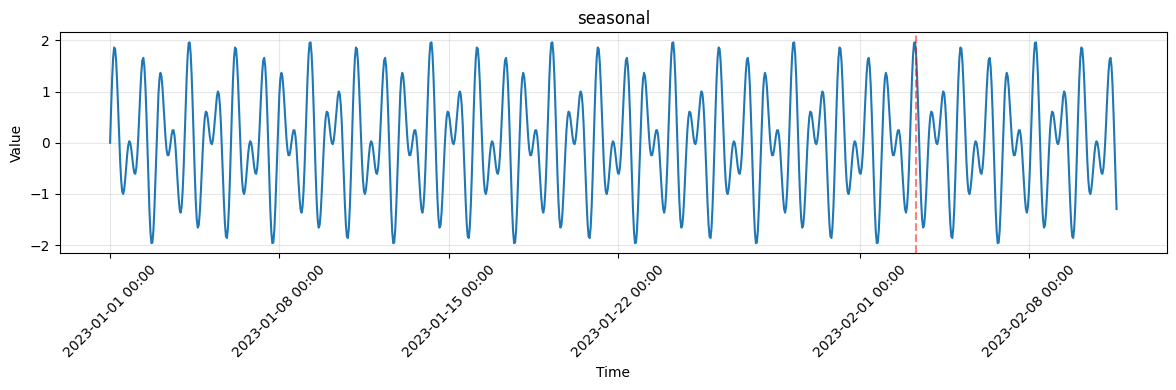

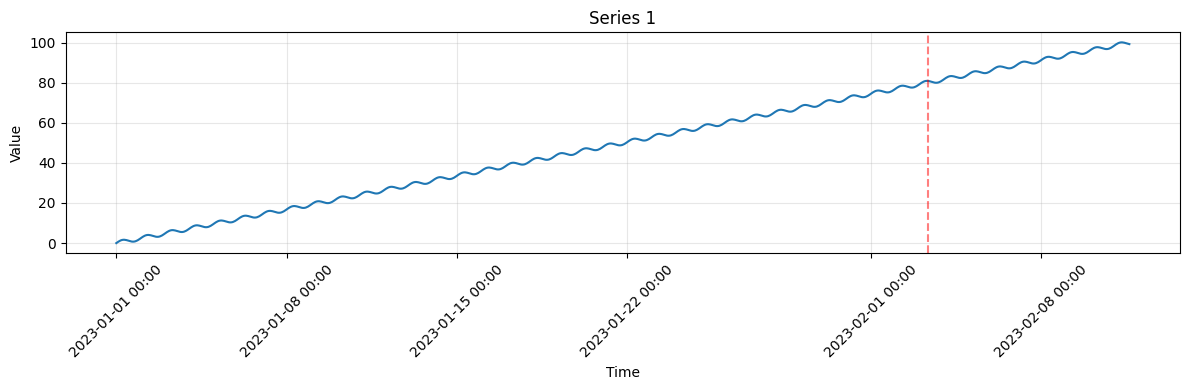

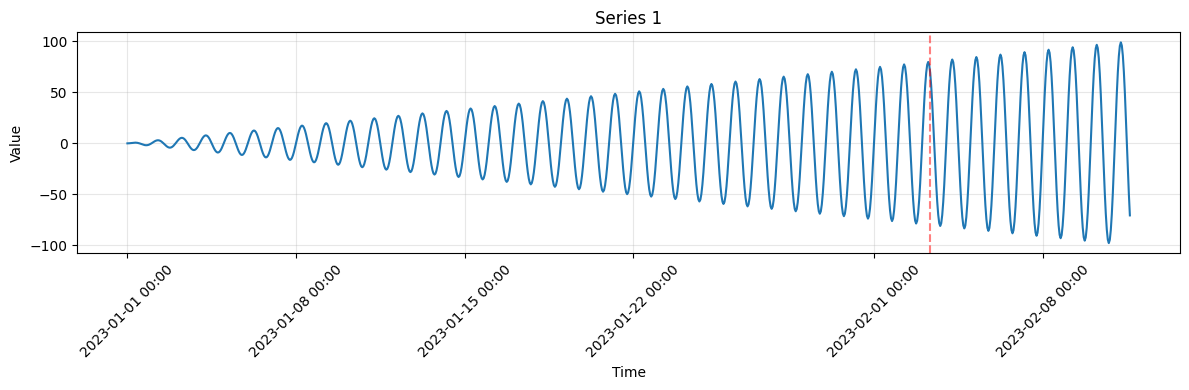

In [6]:
# plot_time_series(noise_hourly, figsize=(12, 4), split=context_length, separate=True)
# plot_time_series(trend_daily, figsize=(12, 4), split=context_length, separate=True)
# plot_time_series(seasonal_hourly, figsize=(12, 4), split=context_length, separate=True)
plot_time_series(seasonal_combined_hourly, figsize=(12, 4), split=context_length, separate=True)
plot_time_series(add_linear_trend_hourly, figsize=(12, 4), split=context_length, separate=True)
plot_time_series(mul_linear_trend_hourly, figsize=(12, 4), split=context_length, separate=True)


In [7]:
type(noise_hourly)

pandas.core.series.Series

In [8]:
# Convert all data to TimeSeriesDataFrame
all_tsdf_map = {
    "noise_hourly": noise_hourly,
    "noise_weekly": noise_weekly,
    "trend_hourly_linear": trend_hourly_linear,
    "trend_hourly_expo": trend_hourly_expo,
    "seasonal_hourly": seasonal_hourly,
    "seasonal_composite": seasonal_combined_hourly,
    "linear_trend_and_seasonal_hourly": add_linear_trend_hourly,
    "linear_trend_multiply_seasonal_hourly_composite": mul_linear_trend_hourly,
}

all_tsdf = []
for key, series in all_tsdf_map.items():
    tsdf = series_to_tsdf(series, item_id=key)
    all_tsdf.append(tsdf)

all_tsdf = TimeSeriesDataFrame(pd.concat(all_tsdf))


In [9]:
from tabpfn_time_series.experimental.features import (
    FeatureTransformer,
    AdditionalCalendarFeature,
    AutoSeasonalFeature,
    RunningIndexFeature,
)

from tabpfn_client import set_access_token
from dotenv import load_dotenv
import os

load_dotenv()

set_access_token(os.getenv("TABPFN_ACCESS_TOKEN"))

feature_transformer = FeatureTransformer(
    [
        RunningIndexFeature(),
        AdditionalCalendarFeature(
            additional_seasonal_features={
                "second_of_minute": [60],
                "minute_of_hour": [60],
            }
        ),
        AutoSeasonalFeature(
            config={
                "max_top_k": 5,
                "detrend_type": "linear",
                "zero_padding_factor": 2,
                "exclude_zero": True
            }
        ),
    ]
)



In [10]:
train_tsdf = all_tsdf.slice_by_timestep(
    start_index=0, end_index=context_length)
test_tsdf = all_tsdf.slice_by_timestep(
    start_index=context_length, end_index=total_length)

test_tsdf_nan_target = test_tsdf.copy()
test_tsdf_nan_target["target"] = np.nan



In [11]:
train_feat_tsdf, test_feat_tsdf = feature_transformer.transform(
    train_tsdf, test_tsdf_nan_target)

In [12]:
from tabpfn_time_series import TabPFNTimeSeriesPredictor

model = TabPFNTimeSeriesPredictor()
all_pred_tsdf = model.predict(train_feat_tsdf, test_feat_tsdf)


Predicting time series: 100%|██████████| 8/8 [00:00<00:00, 556.65it/s]


  Welcome Back! Found existing access token, reusing it for authentication.
  Welcome Back! Found existing access token, reusing it for authentication.
  Welcome Back! Found existing access token, reusing it for authentication.


Processing:   2%|▏         | [00:00<00:04]

  Welcome Back! Found existing access token, reusing it for authentication.
  Welcome Back! Found existing access token, reusing it for authentication.  Welcome Back! Found existing access token, reusing it for authentication.

  Welcome Back! Found existing access token, reusing it for authentication.


Processing:  32%|███▏      | [00:01<00:03]

  Welcome Back! Found existing access token, reusing it for authentication.


Processing: 100%|██████████| [00:01<00:00]
Processing: 100%|██████████| [00:01<00:00]
Processing: 100%|██████████| [00:01<00:00]
Processing: 100%|██████████| [00:01<00:00]
Processing: 100%|██████████| [00:02<00:00]
Processing: 100%|██████████| [00:01<00:00]
Processing: 100%|██████████| [00:04<00:00]
Processing: 100%|██████████| [00:04<00:00]


In [13]:
all_pred_tsdf.item_ids.unique()

Index(['noise_hourly', 'noise_weekly', 'trend_hourly_linear',
       'trend_hourly_expo', 'seasonal_hourly', 'seasonal_composite',
       'linear_trend_and_seasonal_hourly',
       'linear_trend_multiply_seasonal_hourly_composite'],
      dtype='object', name='item_id')

In [14]:
# Reload the plot_pred_and_actual_ts function to ensure we have the latest version
from importlib import reload
import tabpfn_time_series.plot as plot_module
reload(plot_module)
from tabpfn_time_series.plot import plot_pred_and_actual_ts


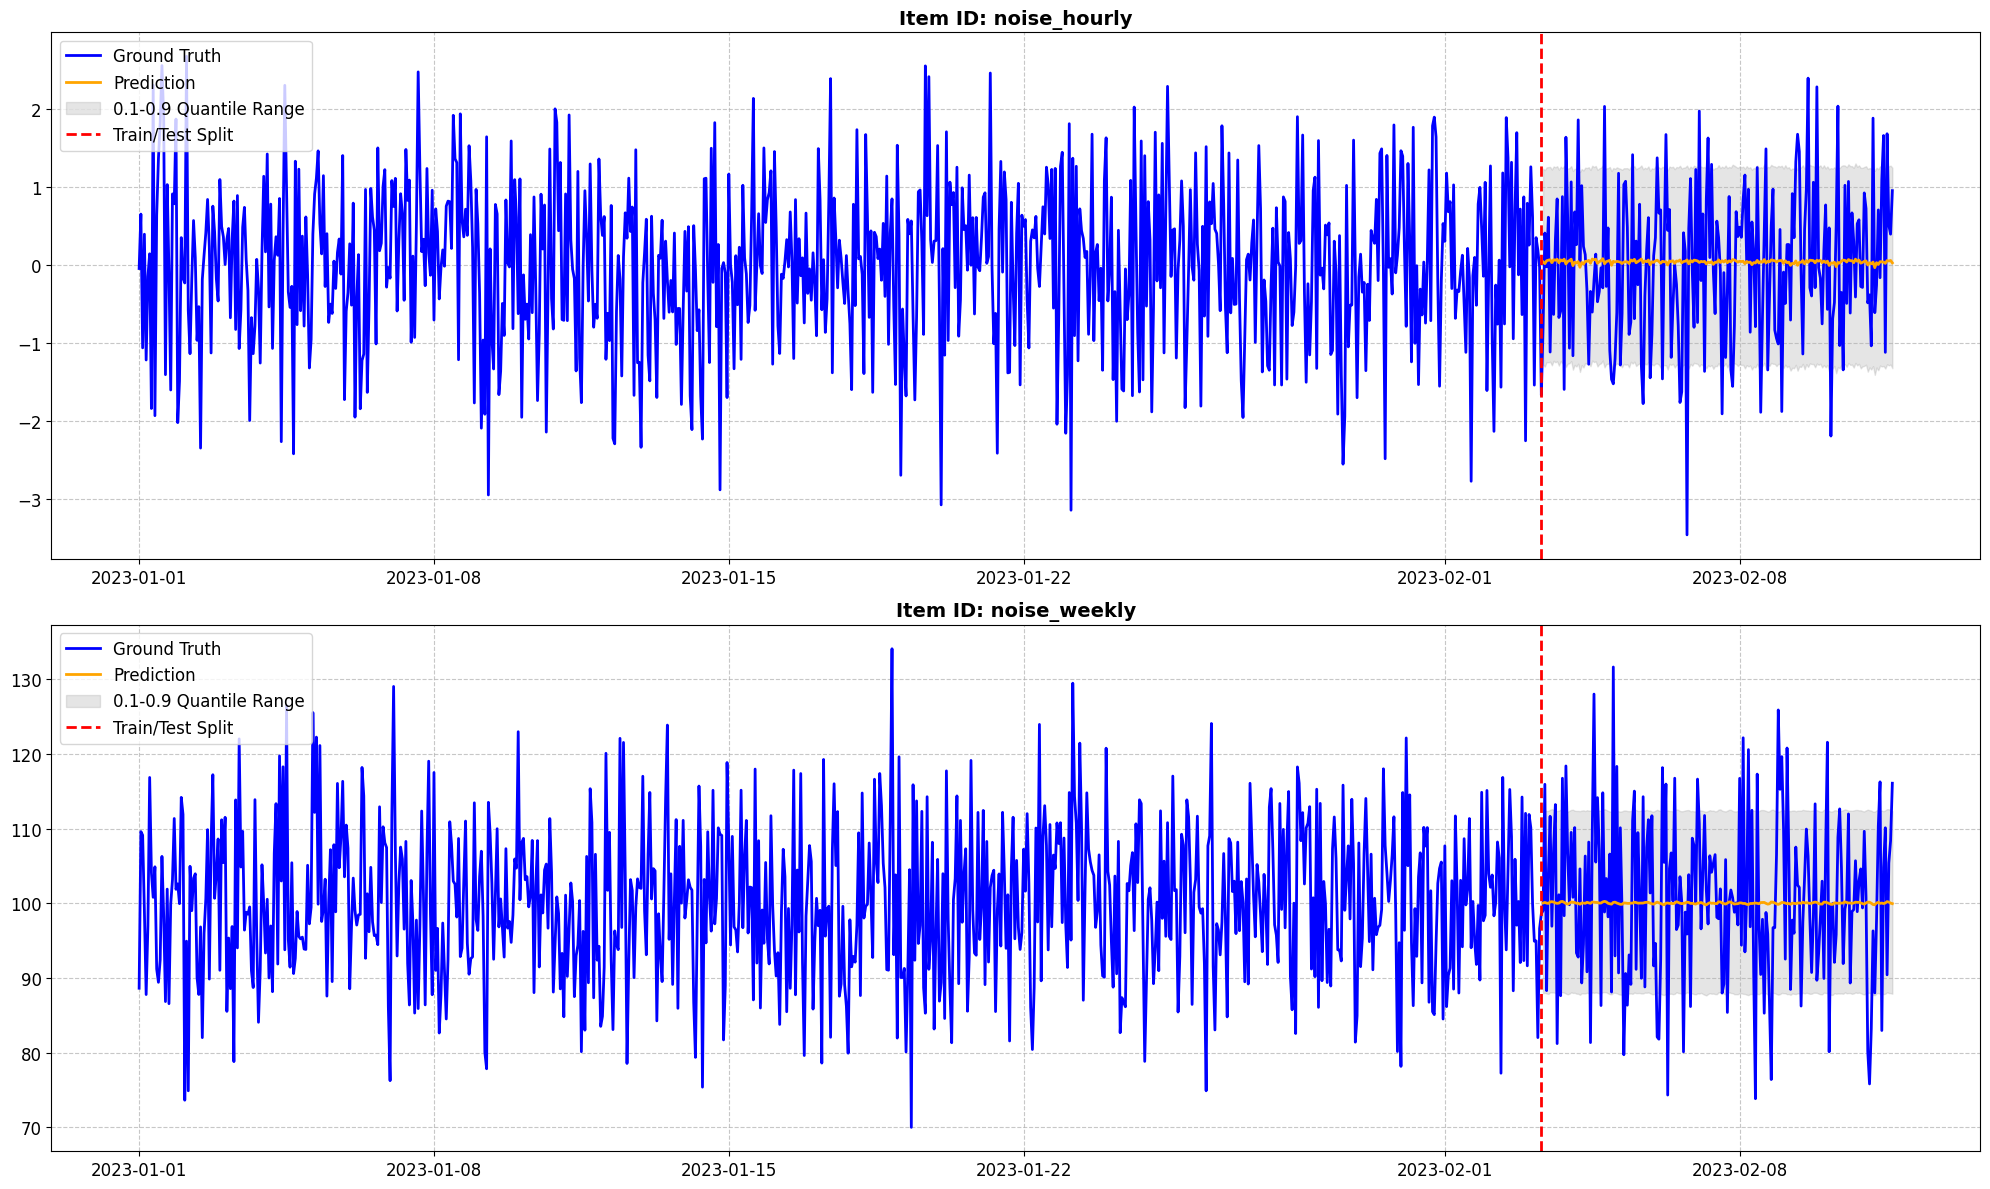

In [15]:

plot_pred_and_actual_ts(
    train=train_tsdf,
    test=test_tsdf,
    pred=all_pred_tsdf,
    item_ids=["noise_hourly", "noise_weekly"],
    save_path=output_dir / "qualitative_noise.pdf",
)

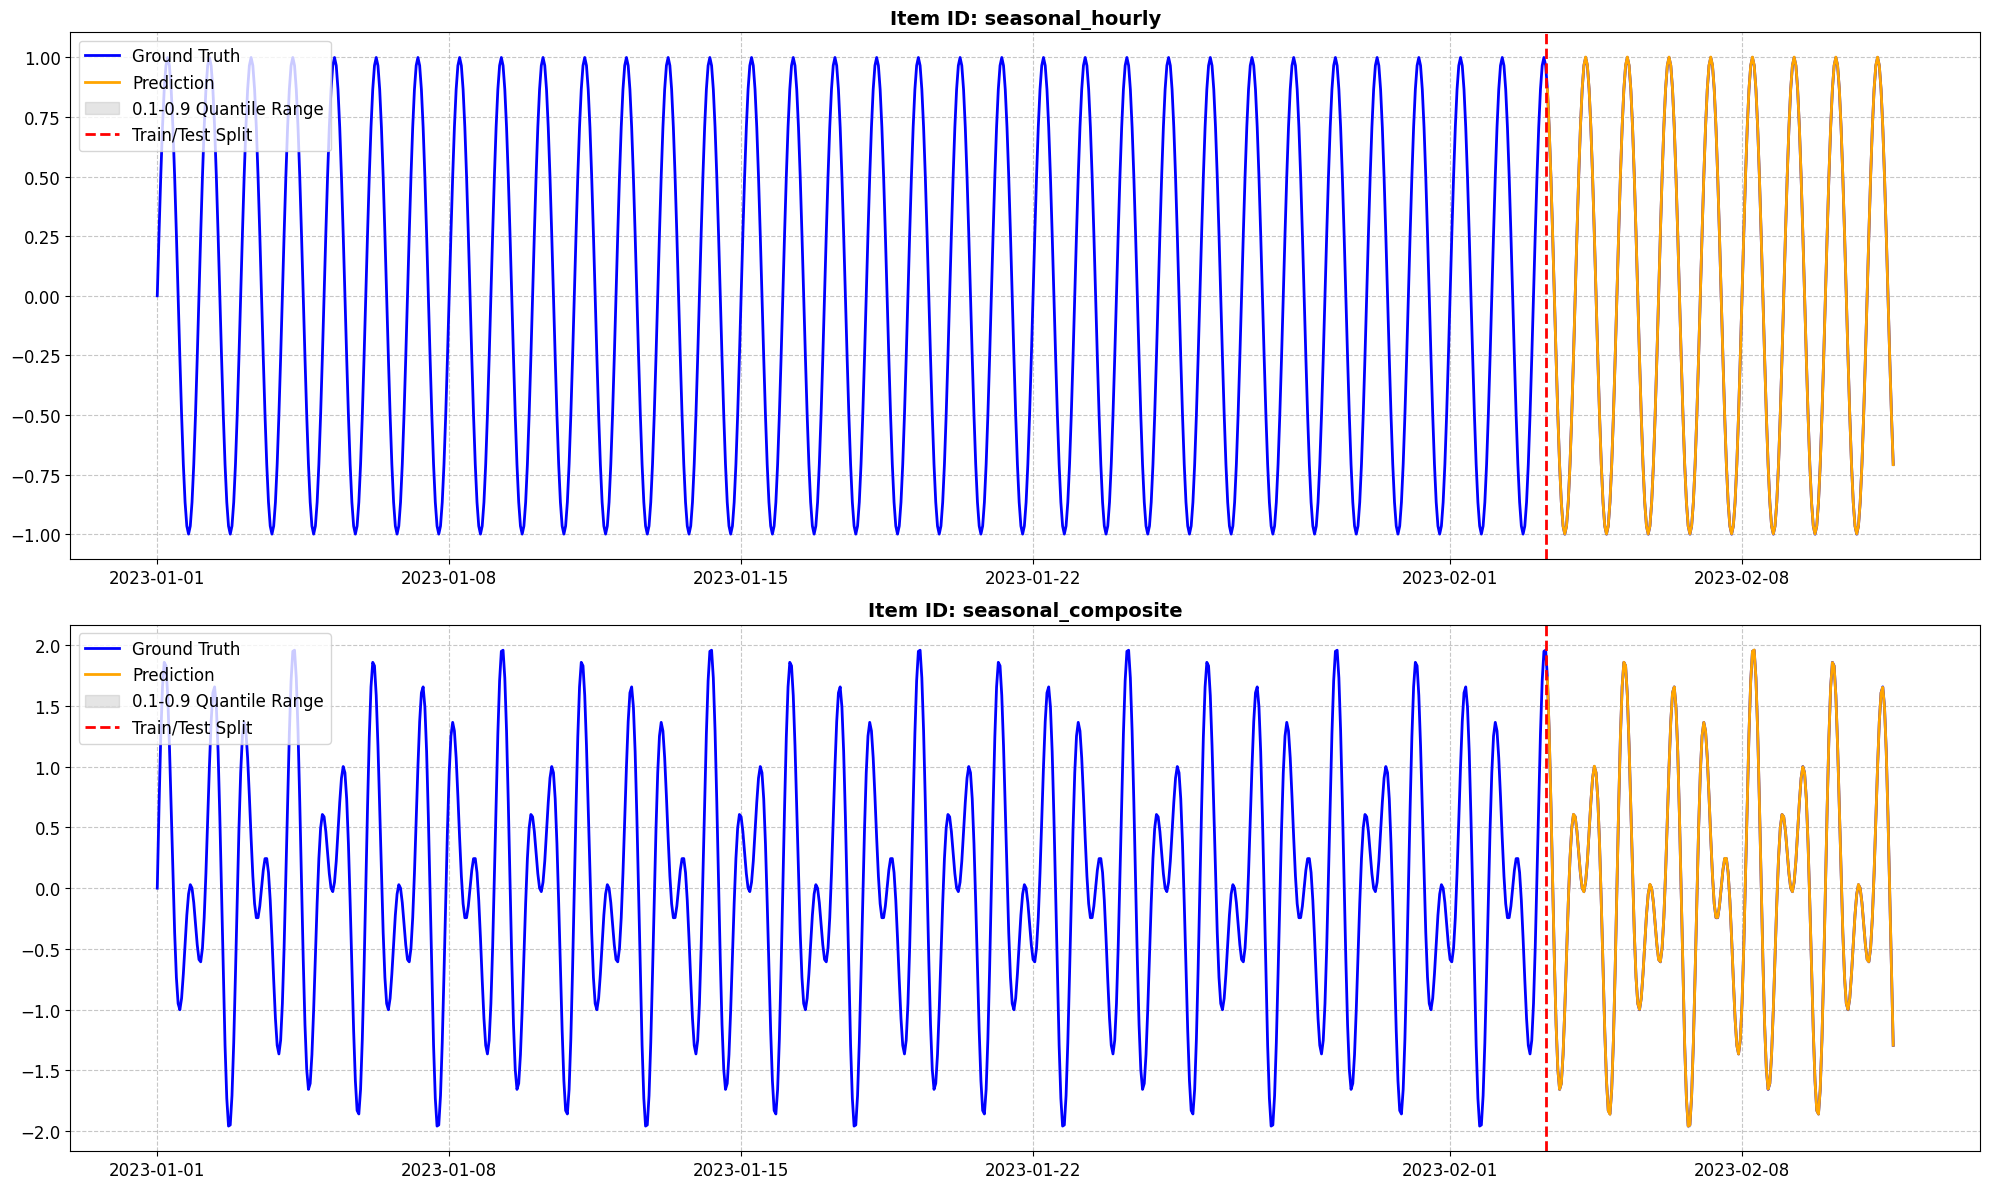

In [16]:
plot_pred_and_actual_ts(
    train=train_tsdf,
    test=test_tsdf,
    pred=all_pred_tsdf,
    item_ids=["seasonal_hourly", "seasonal_composite"],
    save_path=output_dir / "qualitative_seasonal.pdf",
)

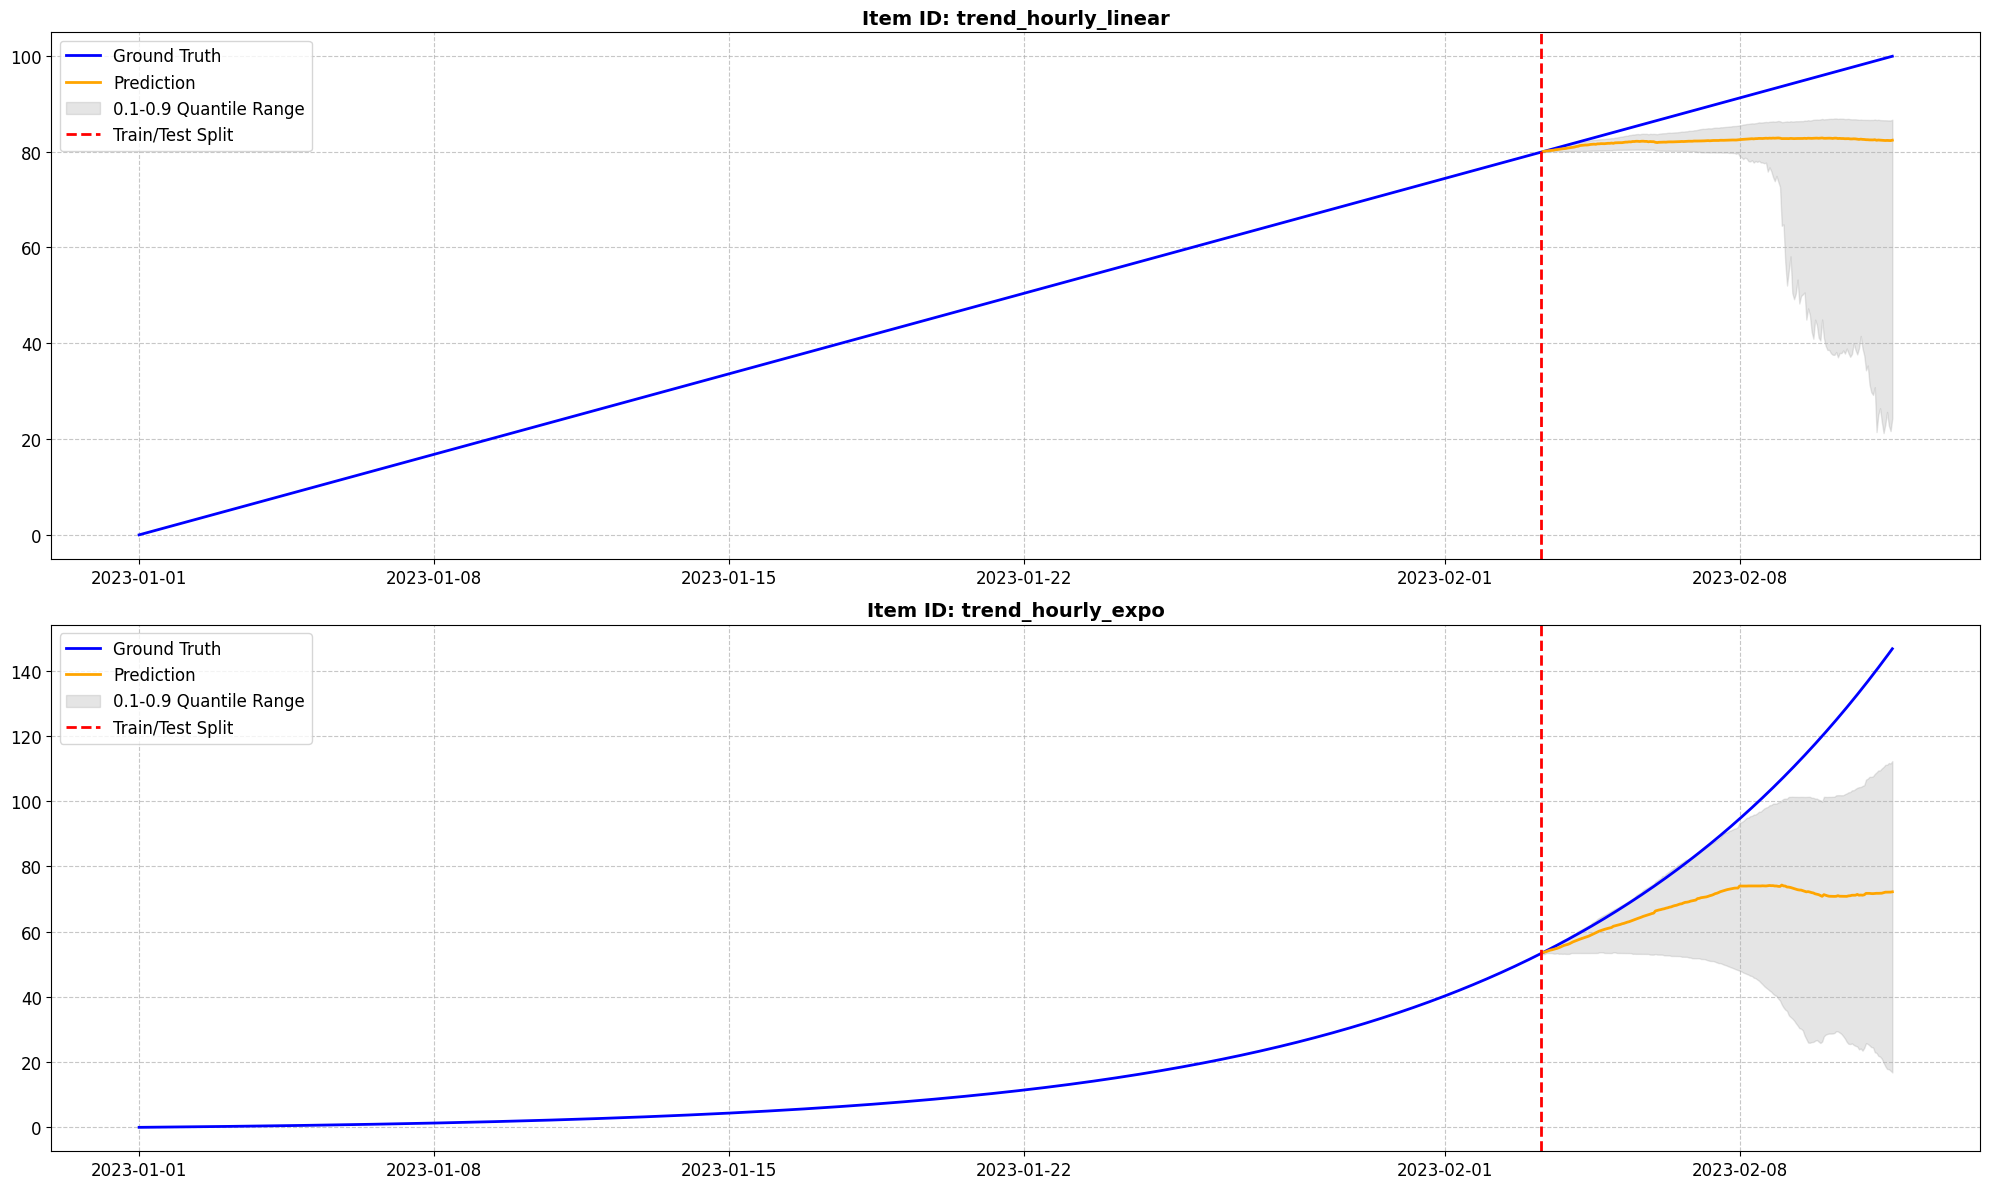

In [17]:
plot_pred_and_actual_ts(
    train=train_tsdf,
    test=test_tsdf,
    pred=all_pred_tsdf,
    item_ids=["trend_hourly_linear", "trend_hourly_expo"],
    save_path=output_dir / "qualitative_trend.pdf",
)

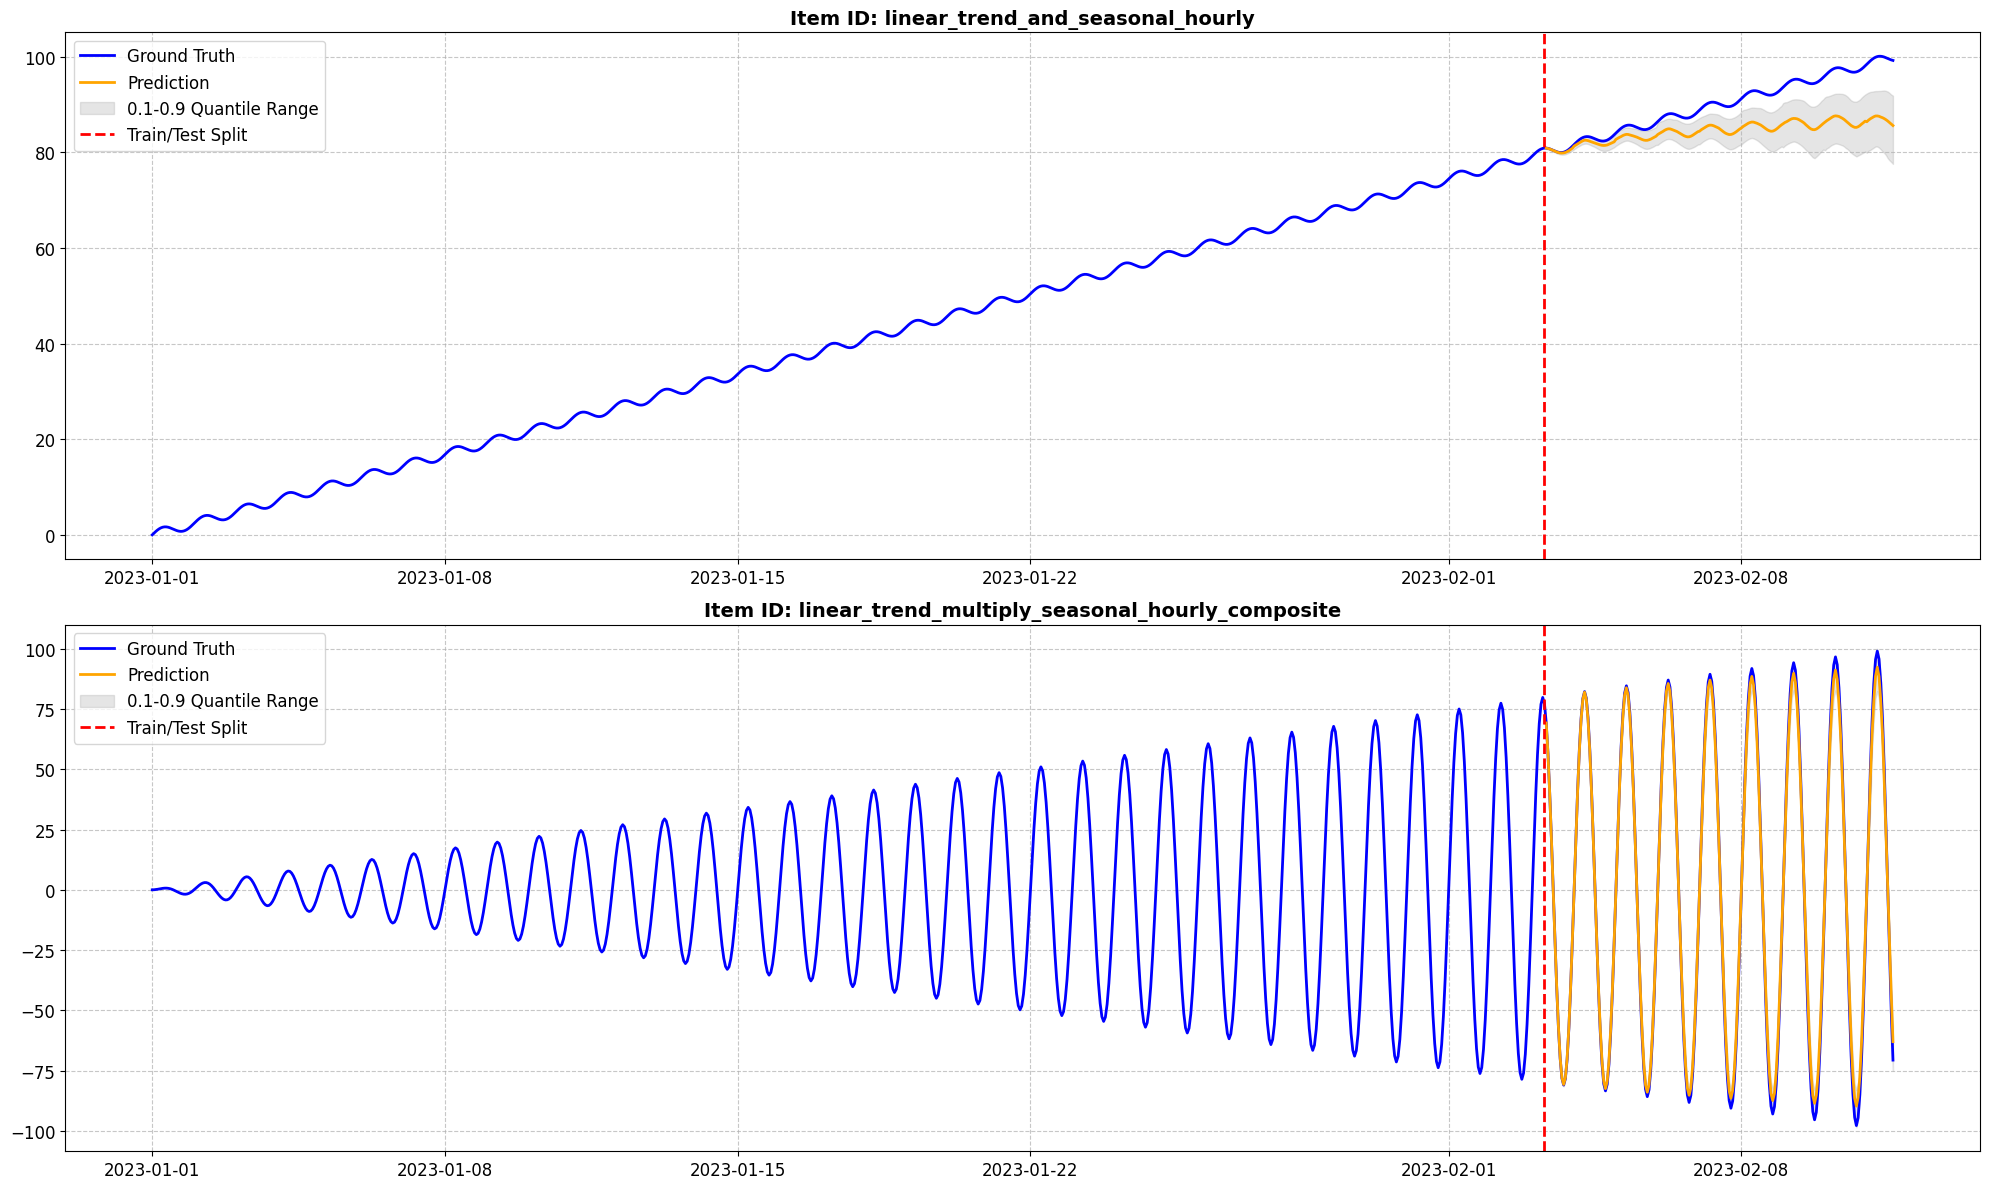

In [18]:
plot_pred_and_actual_ts(
    train=train_tsdf,
    test=test_tsdf,
    pred=all_pred_tsdf,
    item_ids=["linear_trend_and_seasonal_hourly", "linear_trend_multiply_seasonal_hourly_composite"],
    save_path=output_dir / "qualitative_trend_and_seasonal.pdf",
)